In [108]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, make_scorer, auc, roc_curve, precision_recall_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint


In [3]:
df = pd.read_pickle(r'2.featured_employee_data.pkl')

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
df

,employee_id,age,gender,job_role,monthly_income,work_life_balance,job_satisfaction,performance_rating,number_of_promotions,overtime,distance_from_home,education_level,marital_status,number_of_dependents,job_level,company_size,remote_work,leadership_opportunities,innovation_opportunities,company_reputation,employee_recognition,attrition,age_group,has_few_promotions,monthly_income_log,has_many_dependents
0,8410,31,1,Education,5390,Excellent,Medium,Average,2,0,22,Associate Degree,Married,0,Mid,Medium,0,0,0,Excellent,Medium,0,Early_Career_26-35,1,8.592486,0
1,64756,59,0,Media,5534,Poor,High,Low,3,0,21,Master’s Degree,Divorced,3,Mid,Medium,0,0,0,Fair,Low,0,Senior_46+,0,8.618847,0
2,30257,24,0,Healthcare,8159,Good,High,Low,0,0,11,Bachelor’s Degree,Married,3,Mid,Medium,0,0,0,Poor,Low,0,Young_18-25,1,9.006999,0
3,65791,36,0,Education,3989,Good,High,High,1,0,27,High School,Single,2,Mid,Small,1,0,0,Good,Medium,0,Mid_Career_36-45,1,8.291547,0
4,65026,56,1,Education,4821,Fair,Very High,Average,0,1,71,High School,Divorced,0,Senior,Medium,0,0,0,Fair,Medium,0,Senior_46+,1,8.480944,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74493,16243,56,0,Healthcare,7830,Poor,Medium,Average,0,1,40,Associate Degree,Single,0,Senior,Medium,0,0,0,Poor,Medium,0,Senior_46+,1,8.965845,0
74494,47175,30,0,Education,3856,Good,Medium,Average,2,1,45,Master’s Degree,Married,0,Entry,Medium,0,0,0,Good,Medium,1,Early_Career_26-35,1,8.257645,0
74495,12409,52,1,Education,5654,Good,Very High,Below Average,0,0,4,Associate Degree,Married,4,Mid,Small,0,0,0,Good,High,1,Senior_46+,1,8.640295,1
74496,9554,18,1,Education,5276,Fair,High,Average,0,0,13,Bachelor’s Degree,Divorced,3,Mid,Large,0,0,0,Poor,High,0,Young_18-25,1,8.571113,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74498 entries, 0 to 74497
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   employee_id               74498 non-null  int64   
 1   age                       74498 non-null  int64   
 2   gender                    74498 non-null  int64   
 3   job_role                  74498 non-null  category
 4   monthly_income            74498 non-null  int64   
 5   work_life_balance         74498 non-null  category
 6   job_satisfaction          74498 non-null  category
 7   performance_rating        74498 non-null  category
 8   number_of_promotions      74498 non-null  int64   
 9   overtime                  74498 non-null  int64   
 10  distance_from_home        74498 non-null  int64   
 11  education_level           74498 non-null  category
 12  marital_status            74498 non-null  category
 13  number_of_dependents      74498 non-null  int6

In [7]:
# small format fix..
df['education_level'] = df['education_level'].str.replace("’", "", regex=False)

In [8]:
df['education_level'].unique()

array(['Associate Degree', 'Masters Degree', 'Bachelors Degree',
       'High School', 'PhD'], dtype=object)

In [9]:
#Features & Target

features = df.drop('attrition', axis=1)
target = df['attrition']

In [10]:
# Split data

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=42, stratify = target)

In [11]:
# Data preprocessing

numerical_features = [
    'monthly_income_log', 'distance_from_home']

In [12]:
ordinal_education_order = ['High School', 'Associate Degree','Bachelors Degree', 'Masters Degree', 'PhD']
ordinal_job_level_order = ['Entry', 'Mid', 'Senior']
ordinal_wlb_order = ['Poor', 'Fair', 'Good', 'Excellent']
ordinal_job_sat_order = ['Low', 'Medium', 'High', 'Very High']
ordinal_perf_rating_order = ['Low', 'Below Average', 'Average', 'High']
ordinal_rec_order = ['Low', 'Medium', 'High', 'Very High']
ordinal_company_rep_order = ['Poor', 'Fair', 'Good', 'Excellent']

In [13]:
ordinal_features = [
    ('education_level', ordinal_education_order),
    ('job_level', ordinal_job_level_order),
    ('work_life_balance', ordinal_wlb_order),
    ('job_satisfaction', ordinal_job_sat_order),
    ('performance_rating', ordinal_perf_rating_order),
    ('employee_recognition', ordinal_rec_order),
    ('company_reputation', ordinal_company_rep_order),
]

In [14]:
nominal_features = [
    'job_role',
    'marital_status',
    'company_size',
    'age_group', 
    'has_few_promotions',
    'gender', 
    'overtime',
    'remote_work',
    'innovation_opportunities',
    'leadership_opportunities',
    'has_many_dependents'
]

In [15]:
# Create preprocessor

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), nominal_features),
        ('ord', OrdinalEncoder(categories=[cat[1] for cat in ordinal_features]), [cat[0] for cat in ordinal_features])
    ],
    remainder='drop'
    )

In [16]:
# Training LR model

pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(class_weight='balanced'))])
# Using class_weight='balanced' to help with class imbalance

pipeline_lr.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('ohe', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [17]:
pipeline_lr.score(X_test, y_test)

0.7451006711409396

In [18]:
pred = pipeline_lr.predict(X_test)
print(classification_report(y_pred = pred, y_true = y_test))

              precision    recall  f1-score   support

           0       0.77      0.74      0.75      7826
           1       0.72      0.75      0.74      7074

    accuracy                           0.75     14900
   macro avg       0.74      0.75      0.74     14900
weighted avg       0.75      0.75      0.75     14900



In [ ]:
y_proba_lr = pipeline_lr.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
auc_score_lr = roc_auc_score(y_test, y_proba_lr)

print(f"ROC AUC Score (Logistic Regression): {auc_score_lr:.4f}")

ROC AUC Score (Logistic Regression): 0.8358


In [20]:
# Results comments:

# Accuracy = 0.75 -> model predicts correctly 75% (attrition/no attrition) of the employees in the test set.
# Class 0 (No attrition):
    # precision -> When the model predicts an employee will not resign it's correct 77% of the time.
    # recall -> Identifies 74% of the actual employees who did not resign.
    # f1 - score -> 75%, show a reasonable balance btw precision and recall.

# Class 1 (Attrition):
    # precision -> When the model predicts an employee will resign it's correct 72% of the time.
    # recall -> Identifies 75% of the actual employees who did resign.
    # f1 - score -> 74%, show a reasonable balance btw precision and recall.

In [21]:
# Training Random Forest model

pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced', n_jobs=-1)) # random_state = 42 -> common convention
])

pipeline_rf.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('ohe', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [22]:
pipeline_rf.score(X_test, y_test)

0.7366442953020135

In [23]:
pred = pipeline_rf.predict(X_test)
print(classification_report(y_pred = pred, y_true = y_test))

              precision    recall  f1-score   support

           0       0.74      0.76      0.75      7826
           1       0.73      0.71      0.72      7074

    accuracy                           0.74     14900
   macro avg       0.74      0.74      0.74     14900
weighted avg       0.74      0.74      0.74     14900



In [24]:
# Results comments:
# RF model provide slightly worse results than LR.

In [ ]:
# Training XGBoost model

pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss', 
        use_label_encoder=False, 
        n_estimators=200,        
        learning_rate=0.1,       
        random_state=42,
        n_jobs=-1,               
        ))
])

In [26]:
pipeline_xgb.fit(X_train, y_train)

c:\Users\nilvi\OneDrive\Escritorio\Ironhack\Week9\Final_Project\employee-attrition-prediction-model\my_ml_env_311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:42:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('ohe', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [27]:
pipeline_xgb.score(X_test, y_test)

0.7504697986577181

In [28]:
pred = pipeline_xgb.predict(X_test)
print(classification_report(y_pred = pred, y_true = y_test))

              precision    recall  f1-score   support

           0       0.77      0.76      0.76      7826
           1       0.73      0.74      0.74      7074

    accuracy                           0.75     14900
   macro avg       0.75      0.75      0.75     14900
weighted avg       0.75      0.75      0.75     14900



In [29]:
# Results comments:
# Very similar results vs LR.

In [30]:
########################################

In [31]:
y_pred_xgb = pipeline_xgb.predict(X_test)
y_proba_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]


Confusion Matrix:


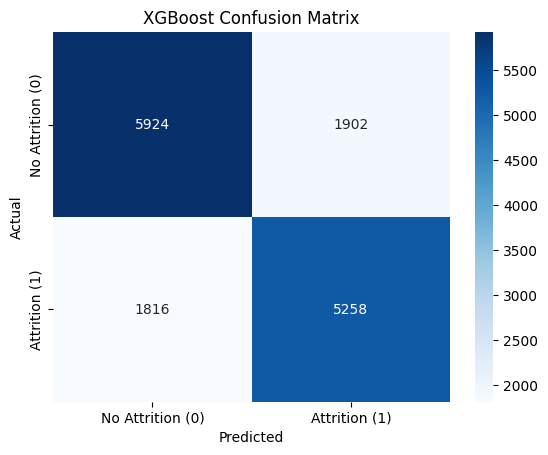

In [32]:
print("\nConfusion Matrix:")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['No Attrition (0)', 'Attrition (1)'], yticklabels=['No Attrition (0)', 'Attrition (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()

In [33]:
auc_score_xgb = roc_auc_score(y_test, y_proba_xgb)
print(f"\nROC AUC Score: {auc_score_xgb:.4f}")


ROC AUC Score: 0.8426


In [34]:
feature_names_processed = pipeline_xgb.named_steps['preprocessor'].get_feature_names_out()
importances_xgb = pipeline_xgb.named_steps['classifier'].feature_importances_

In [35]:
feature_importances_xgb_df = pd.DataFrame({'feature': feature_names_processed, 'importance': importances_xgb})
feature_importances_xgb_df = feature_importances_xgb_df.sort_values(by='importance', ascending=False)


In [36]:
print(feature_importances_xgb_df.head(15))

                        feature  importance
9    ohe__marital_status_Single    0.194368
32               ord__job_level    0.156653
23           ohe__remote_work_0    0.137303
17    ohe__has_few_promotions_0    0.065453
33       ord__work_life_balance    0.057364
29   ohe__has_many_dependents_0    0.051481
19                ohe__gender_0    0.039581
31         ord__education_level    0.027137
8   ohe__marital_status_Married    0.026987
37      ord__company_reputation    0.025915
21              ohe__overtime_0    0.019922
16   ohe__age_group_Young_18-25    0.018656
34        ord__job_satisfaction    0.018246
1       num__distance_from_home    0.013113
35      ord__performance_rating    0.012497


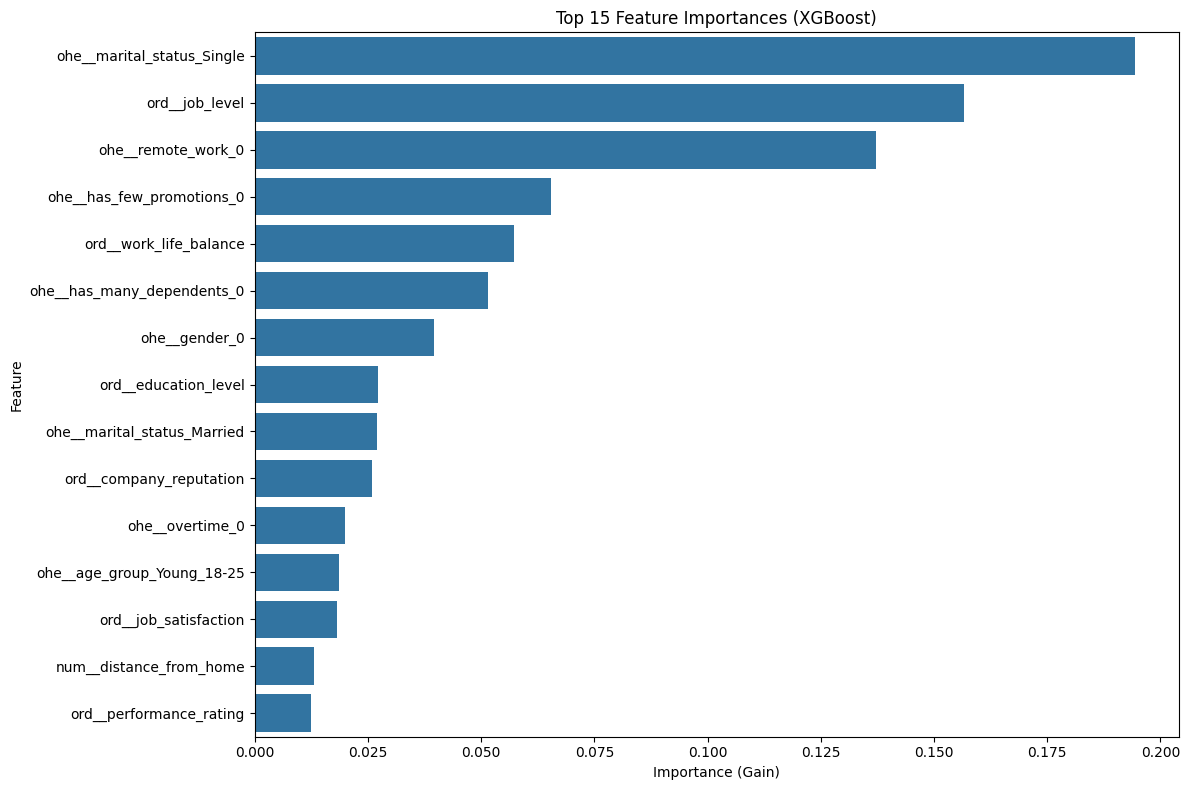

In [37]:
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances_xgb_df.head(15))
plt.title('Top 15 Feature Importances (XGBoost)')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [38]:
##############################

In [39]:
# Hyperparameter tuning for XGBoost using RandomizedSearchCV

In [40]:
base_xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1
    ))
])

In [ ]:
param_distributions = {
    'classifier__n_estimators': randint(100, 1000),       
    'classifier__learning_rate': uniform(0.01, 0.3),      
    'classifier__max_depth': randint(3, 10),              
    'classifier__subsample': uniform(0.6, 0.4),           
    'classifier__colsample_bytree': uniform(0.6, 0.4),    
    'classifier__gamma': uniform(0, 0.5),                 
    'classifier__reg_alpha': uniform(0, 0.5),             
    'classifier__reg_lambda': uniform(0.5, 0.5),          
    'classifier__min_child_weight': randint(1, 10),       
    
}



In [ ]:
# Setup RandomizedSearchCV
# n_iter: Number of parameter settings that are sampled. Trade-off between accuracy and runtime.
# cv: Number of folds for cross-validation.
# scoring: Metric to optimize. 'roc_auc' is good for binary classification.
# verbose: Higher values print more messages.

random_search = RandomizedSearchCV(
    estimator=base_xgb_pipeline,
    param_distributions=param_distributions,
    n_iter=50, # Number of random combinations to try. Increase for more thorough search.
    cv=5,      # 5-fold cross-validation
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1, # Use all available cores for tuning
    verbose=2
)

In [43]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\nilvi\OneDrive\Escritorio\Ironhack\Week9\Final_Project\employee-attrition-prediction-model\my_ml_env_311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:55:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,estimator,"Pipeline(step...=None, ...))])"
,param_distributions,"{'classifier__colsample_bytree': <scipy.stats....001DF1E5D63D0>, 'classifier__gamma': <scipy.stats....001DF1E5D7050>, 'classifier__learning_rate': <scipy.stats....001DF1E2C8A50>, 'classifier__max_depth': <scipy.stats....001DF1E2CB990>, ...}"
,n_iter,50
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [44]:
print("\n--- Hyperparameter Tuning Results ---")
print(f"Best ROC AUC score found: {random_search.best_score_:.4f}")
print("Best parameters found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")


--- Hyperparameter Tuning Results ---
Best ROC AUC score found: 0.8492
Best parameters found:
  classifier__colsample_bytree: 0.7275902521175045
  classifier__gamma: 0.4224376554847273
  classifier__learning_rate: 0.01698158072074776
  classifier__max_depth: 4
  classifier__min_child_weight: 3
  classifier__n_estimators: 716
  classifier__reg_alpha: 0.2480187271467031
  classifier__reg_lambda: 0.8464451793459697
  classifier__subsample: 0.739334641781279


In [84]:
model_xgb =random_search.best_estimator_
model_xgb

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('ohe', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [85]:
model_xgb.score(X_test, y_test)

0.7556375838926175

In [86]:
pred = model_xgb.predict(X_test)
print(classification_report(y_pred = pred, y_true = y_test))

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      7826
           1       0.74      0.75      0.74      7074

    accuracy                           0.76     14900
   macro avg       0.76      0.76      0.76     14900
weighted avg       0.76      0.76      0.76     14900



In [87]:
auc_score_model_xgb = roc_auc_score(y_test, model_xgb.predict_proba(X_test)[:, 1])
print(f'ROC AUC Score (XGB Best): {auc_score_model_xgb}')

ROC AUC Score (XGB Best): 0.8484693067286712


In [83]:
print("\n--- STAGE 2: Performing Refined Randomized Search ---")


--- STAGE 2: Performing Refined Randomized Search ---


In [ ]:
# Extract best parameters from the broad search
best_params_broad = random_search.best_params_

In [89]:
# Define narrower ranges around the best parameters found
param_distributions_fine = {
    'classifier__n_estimators': randint(max(1, int(best_params_broad['classifier__n_estimators'] * 0.8)),
                                        int(best_params_broad['classifier__n_estimators'] * 1.2) + 1),
    'classifier__learning_rate': uniform(max(0.001, best_params_broad['classifier__learning_rate'] * 0.75),
                                         min(1.0, best_params_broad['classifier__learning_rate'] * 1.5) -
                                         max(0.001, best_params_broad['classifier__learning_rate'] * 0.75)),
    'classifier__max_depth': randint(max(1, best_params_broad['classifier__max_depth'] - 2),
                                     best_params_broad['classifier__max_depth'] + 3),
    'classifier__subsample': uniform(max(0.5, best_params_broad['classifier__subsample'] - 0.15), 0.3),
    'classifier__colsample_bytree': uniform(max(0.5, best_params_broad['classifier__colsample_bytree'] - 0.15), 0.3),
    'classifier__gamma': uniform(max(0.0, best_params_broad['classifier__gamma'] * 0.5),
                                 min(1.0, best_params_broad['classifier__gamma'] * 2.0) -
                                 max(0.0, best_params_broad['classifier__gamma'] * 0.5)),
    'classifier__reg_alpha': uniform(max(0.0, best_params_broad['classifier__reg_alpha'] * 0.5),
                                     min(1.0, best_params_broad['classifier__reg_alpha'] * 2.0) -
                                     max(0.0, best_params_broad['classifier__reg_alpha'] * 0.5)),
    'classifier__reg_lambda': uniform(max(0.0, best_params_broad['classifier__reg_lambda'] * 0.5),
                                      min(1.0, best_params_broad['classifier__reg_lambda'] * 2.0) -
                                      max(0.0, best_params_broad['classifier__reg_lambda'] * 0.5)),
    'classifier__min_child_weight': randint(max(1, best_params_broad['classifier__min_child_weight'] - 2),
                                            best_params_broad['classifier__min_child_weight'] + 3),
}

In [ ]:
random_search_fine = RandomizedSearchCV(
    estimator=base_xgb_pipeline, 
    param_distributions=param_distributions_fine,
    n_iter=75, 
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

In [91]:
random_search_fine.fit(X_train, y_train)


Fitting 5 folds for each of 75 candidates, totalling 375 fits


c:\Users\nilvi\OneDrive\Escritorio\Ironhack\Week9\Final_Project\employee-attrition-prediction-model\my_ml_env_311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:41:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,estimator,"Pipeline(step...=None, ...))])"
,param_distributions,"{'classifier__colsample_bytree': <scipy.stats....001DF1EC3FC90>, 'classifier__gamma': <scipy.stats....001DF1EC3D990>, 'classifier__learning_rate': <scipy.stats....001DF1EBE91D0>, 'classifier__max_depth': <scipy.stats....001DF1EC5C950>, ...}"
,n_iter,75
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [92]:
print("\n--- Hyperparameter Tuning Results ---")
print(f"Best ROC AUC score found: {random_search_fine.best_score_:.4f}")
print("Best parameters found:")
for param, value in random_search_fine.best_params_.items():
    print(f"  {param}: {value}")


--- Hyperparameter Tuning Results ---
Best ROC AUC score found: 0.8497
Best parameters found:
  classifier__colsample_bytree: 0.7827793829369468
  classifier__gamma: 0.6014569107609855
  classifier__learning_rate: 0.024757764146424284
  classifier__max_depth: 3
  classifier__min_child_weight: 1
  classifier__n_estimators: 731
  classifier__reg_alpha: 0.47380142512793455
  classifier__reg_lambda: 0.7551430956983024
  classifier__subsample: 0.7057856196432355


In [93]:
fine_model_xgb =random_search.best_estimator_
fine_model_xgb

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('ohe', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [94]:
fine_model_xgb.score(X_test, y_test)

0.7556375838926175

In [95]:
pred = fine_model_xgb.predict(X_test)
print(classification_report(y_pred = pred, y_true = y_test))

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      7826
           1       0.74      0.75      0.74      7074

    accuracy                           0.76     14900
   macro avg       0.76      0.76      0.76     14900
weighted avg       0.76      0.76      0.76     14900



In [96]:
auc_score_fine_model_xgb = roc_auc_score(y_test, fine_model_xgb.predict_proba(X_test)[:, 1])
print(f'ROC AUC Score (XGB Best): {auc_score_fine_model_xgb}')

ROC AUC Score (XGB Best): 0.8484693067286712


In [97]:
# --- 1. Define the models to compare ---
# IMPORTANT: Ensure these variables are defined and hold your TRAINED pipeline objects
# from your previous code execution in the same VS Code file.

models = {
    "Logistic Regression": pipeline_lr,
    "Random Forest": pipeline_rf,
    "XGBoost (Untuned)": pipeline_xgb,
    "XGBoost (Broad Tuned)": model_xgb,
    "XGBoost (Fine Tuned)": fine_model_xgb
}


In [ ]:
# --- A. Quantitative Model Comparison ---
print("\n--- A. Quantitative Model Comparison ---")


--- A. Quantitative Model Comparison ---


In [ ]:
results = []

for name, model in models.items():
    print(f"Evaluating {name}...")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    # Extract metrics for Class 0 (No Attrition) and Class 1 (Attrition)
    precision_class0 = report['0'].get('precision', 0)
    recall_class0 = report['0'].get('recall', 0)
    f1_class0 = report['0'].get('f1-score', 0)

    precision_class1 = report['1'].get('precision', 0)
    recall_class1 = report['1'].get('recall', 0)
    f1_class1 = report['1'].get('f1-score', 0)


    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision (Class 0)': precision_class0, 
        'Recall (Class 0)': recall_class0,      
        'Precision (Class 1)': precision_class1,
        'Recall (Class 1)': recall_class1,
        'F1-Score (Class 1)': f1_class1,
        'ROC AUC': roc_auc
    })

results_df = pd.DataFrame(results)
results_df = results_df.round(4).set_index('Model')
results_df

Evaluating Logistic Regression...
Evaluating Random Forest...
Evaluating XGBoost (Untuned)...
Evaluating XGBoost (Broad Tuned)...
Evaluating XGBoost (Fine Tuned)...


,Accuracy,Precision (Class 0),Recall (Class 0),Precision (Class 1),Recall (Class 1),F1-Score (Class 1),ROC AUC
Model,,,,,,,
Logistic Regression,0.7451,0.7651,0.7427,0.7243,0.7478,0.7358,0.8358
Random Forest,0.7366,0.7441,0.7599,0.7280,0.7109,0.7194,0.8287
XGBoost (Untuned),0.7505,0.7654,0.7570,0.7344,0.7433,0.7388,0.8426
XGBoost (Broad Tuned),0.7556,0.7691,0.7642,0.7410,0.7461,0.7435,0.8485
XGBoost (Fine Tuned),0.7556,0.7691,0.7642,0.7410,0.7461,0.7435,0.8485


In [110]:
# Summary comments:
    # Both the XGBoost (Broad Tuned) and XGBoost (Fine Tuned) models consistently show the best performance across almost all metrics. 
    # They achieve the highest Accuracy (0.7556), the highest ROC AUC (0.8485), and the best balance of Precision and Recall for both classes 
    # (e.g., for Class 1, Precision = 0.7410, Recall = 0.7461).

    # This indicates that XGBoost, particularly with thoughtful hyperparameter tuning, is the most effective model for attrition prediction task among those tested.

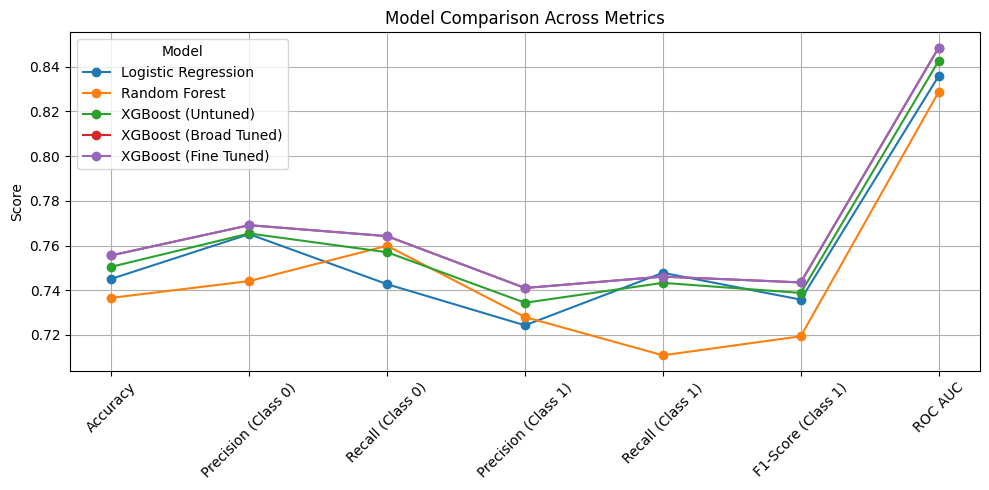

In [113]:
#Model results comparison

results_df.T.plot(kind='line', marker='o', figsize=(10, 5))
plt.title("Model Comparison Across Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


--- B. Visual Model Comparison (ROC & Precision-Recall Curves) ---


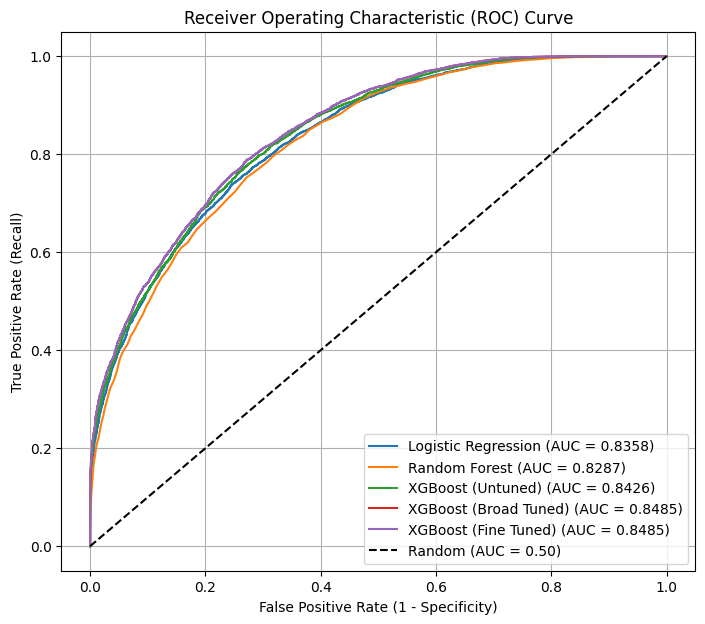

In [103]:
# --- B. Visual Model Comparison ---
print("\n--- B. Visual Model Comparison (ROC & Precision-Recall Curves) ---")
plt.figure(figsize=(18, 7))

# ROC Curve Plot
plt.subplot(1, 2, 1)
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)

In [ ]:
# Summary comments:
    # True Positive Rate (TPR) / Recall: This is on the Y-axis. It measures how many of the actual positive cases (employees who will attrit) were correctly identified.
    # False Positive Rate (FPR): This is on the X-axis. It measures how many of the actual negative cases (employees who will not attrit) were incorrectly identified as positive (attritors).

    # The Diagonal Dashed Line (Random (AUC = 0.50)): This line represents a classifier that performs no better than random chance. 
        # A good model's ROC curve should be as far away from this line as possible and towards the top-left corner.
    # Area Under the Curve (AUC): The ROC AUC is the area under the ROC curve. It ranges from 0 to 1.
        # An AUC of 0.50 means the model is as good as random.
        # An AUC of 1.00 means a perfect classifier.
        # The higher the AUC, the better the model's ability to distinguish between positive and negative classes across all possible thresholds.

    # ROC curve clearly shows all models performing significantly better than random. The two tuned XGBoost models have the highest AUC (0.8485), 
        # indicating they are the best at discriminating between attritors and non-attritors across all possible classification thresholds.



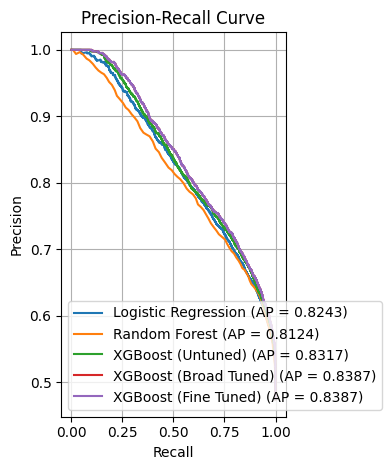

In [109]:
# Precision-Recall Curve Plot
plt.subplot(1, 2, 2)
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, label=f'{name} (AP = {pr_auc:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Summary comments:
    # The Precision-Recall curve is a vital tool for evaluating binary classification models, especially when dealing with imbalanced datasets or when the costs of different types of errors are unequal.
    # All models start near (Recall=0, Precision=1.0) and generally decrease in Precision as Recall increases. 
        # This is the expected behavior, as it becomes harder to maintain perfect precision while trying to identify more and more of the positive cases.

    # The Area Under the Precision-Recall Curve (often called Average Precision or AP) is provided in the legend.
        # Higher AP is better. Similar to the ROC AUC, a higher AP indicates a better model in terms of both Precision and Recall, particularly when focusing on the positive class.

    # XGBoost (Tuned) maintains its lead: The XGBoost (Broad Tuned) and XGBoost (Fine Tuned) models have the highest AP (Average Precision) of 0.8387, 
        # confirming their superior performance in identifying attritors while maintaining good precision.


--- Confusion Matrices ---


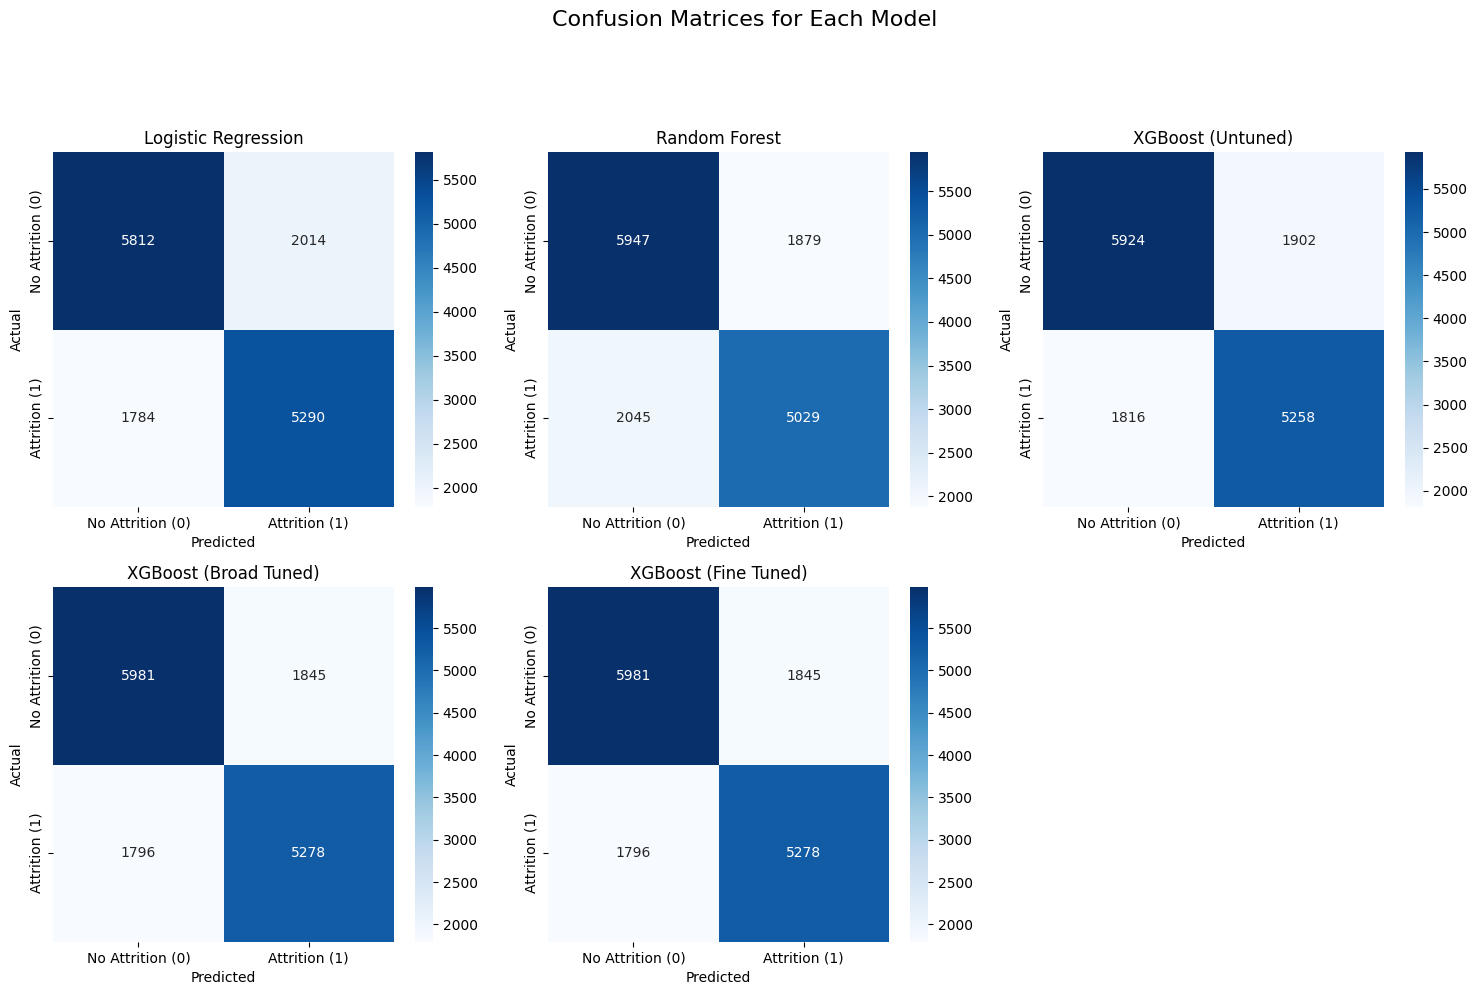

In [105]:
# Confusion Matrix Plots
print("\n--- Confusion Matrices ---")
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i in range(len(models), len(axes)):
    fig.delaxes(axes[i])

fig.suptitle('Confusion Matrices for Each Model', fontsize=16, y=1.02)

for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Attrition (0)', 'Attrition (1)'],
                yticklabels=['No Attrition (0)', 'Attrition (1)'],
                ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# Summary comments:
    # These matrices visually reinforce the quantitative results. The tuned XGBoost models are slightly better at correctly classifying both attritors and non-attritors, 
        # leading to fewer misclassifications in both directions (FP and FN).


--- C. Feature Importance Comparison ---


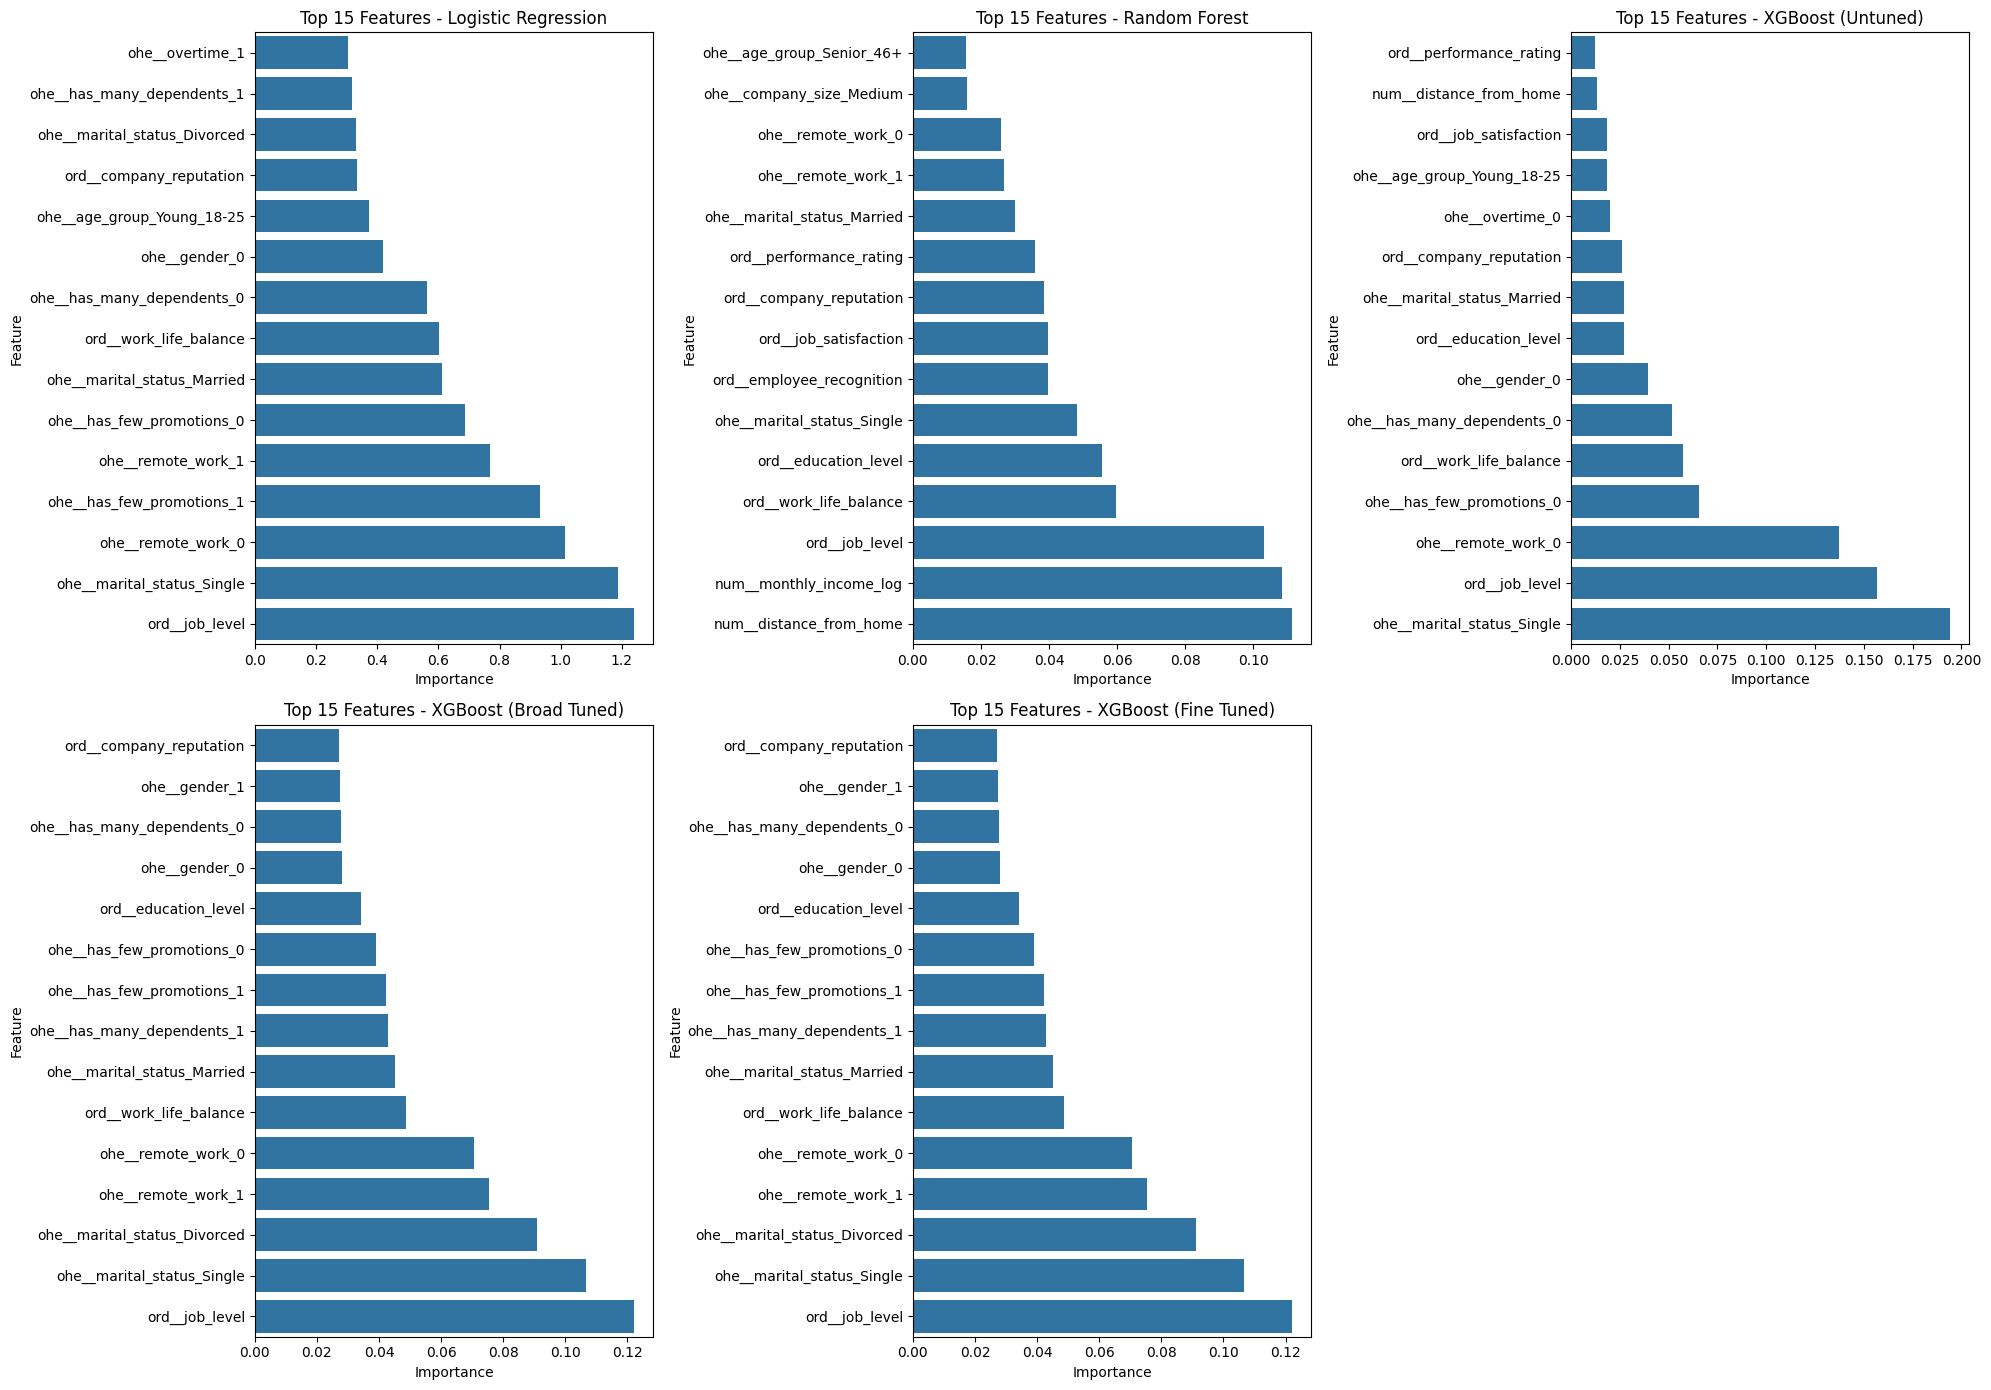

In [106]:
# --- C. Feature Importance Comparison ---
print("\n--- C. Feature Importance Comparison ---")

feature_names_processed = preprocessor.get_feature_names_out()
feature_importances_dfs = {}

for name, model_pipeline in models.items():
    classifier = model_pipeline.named_steps['classifier']

    if hasattr(classifier, 'feature_importances_'):
        importances = classifier.feature_importances_
        feature_importances_dfs[name] = pd.DataFrame({'feature': feature_names_processed, 'importance': importances})
        feature_importances_dfs[name] = feature_importances_dfs[name].sort_values(by='importance', ascending=False)
    elif hasattr(classifier, 'coef_'):
        lr_coefs = classifier.coef_[0] if classifier.coef_.ndim > 1 else classifier.coef_
        feature_importances_dfs[name] = pd.DataFrame({
            'feature': feature_names_processed,
            'importance': np.abs(lr_coefs)
        })
        feature_importances_dfs[name] = feature_importances_dfs[name].sort_values(by='importance', ascending=False)
    else:
        print(f"Warning: {name} model does not have 'feature_importances_' or 'coef_' attribute for importance.")

n_top_features = 15
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
axes = axes.flatten()
for i in range(len(models), len(axes)):
    fig.delaxes(axes[i])

for i, (name, df_imp) in enumerate(feature_importances_dfs.items()):
    if not df_imp.empty:
        sns.barplot(x='importance', y='feature', data=df_imp.head(n_top_features), ax=axes[i])
        axes[i].set_title(f'Top {n_top_features} Features - {name}')
        axes[i].set_xlabel('Importance')
        axes[i].set_ylabel('Feature')
        axes[i].invert_yaxis()
    else:
        axes[i].set_title(f'{name} - No Feature Importance Data')
        axes[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Summary comments: 
    # This chart shows top15 features ranked by their importance in the model after hyperparameter tuning. 
        # This tells you how valuable each feature was in building the model to make accurate predictions
        # In the XGBoost case the meaning of importance is how much a feature contributes to reducing error when it's used in a split across all trees.
    
    # top3 contributors are:
    # job_level: Most important —> job level (ordinal encoded) is highly predictive of attrition. Seniority likely correlates with retention or turnover.
    # marital_status_single -> being single increases attrition risk - possibly linked to mobility or lack of family ties.
    # marital_status_divorced -> also relevant, indicating life stress or flexibility..

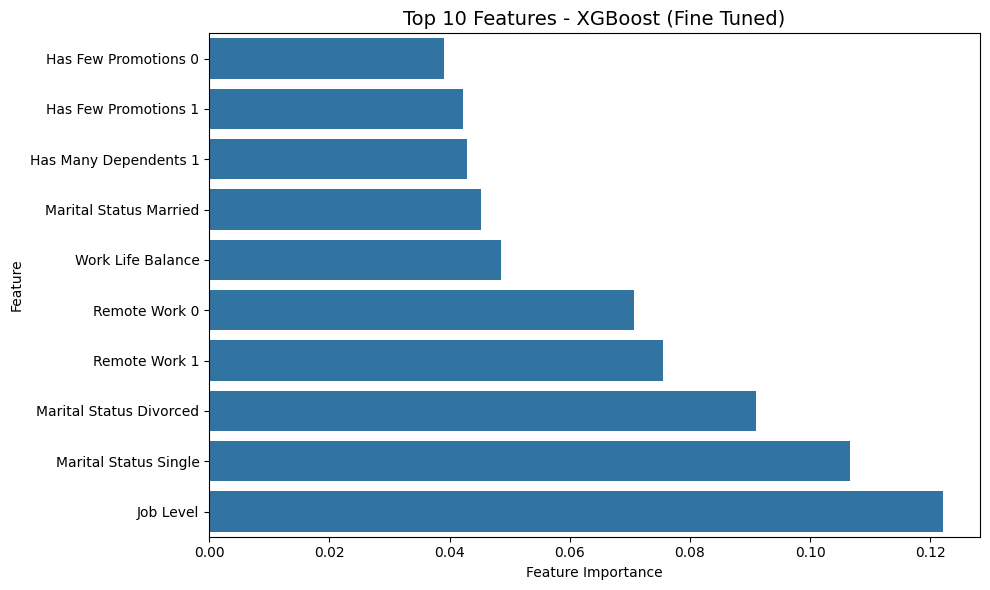

In [121]:
#Top 10 features for XGBoost best model

xgb_ft_key = 'XGBoost (Fine Tuned)'  # Update this if your model is named differently

# --- B. Clean-up function for feature names ---
def clean_feature_name(name):
    # Remove prefixes from transformers
    name = name.replace('ohe__', '')
    name = name.replace('num__', '')
    name = name.replace('scaler__', '')
    name = name.replace('ord__', '')
    
    # Clean formatting
    name = name.replace('_', ' ')
    name = name.replace('binned', 'bin')
    name = name.replace('(', '')
    name = name.replace(')', '')
    name = name.replace('[', '')
    name = name.replace(']', '')
    name = name.replace(',', '–')  # use en-dash for ranges

    return name.title().strip()

# --- C. Extract and plot top 10 features ---
if xgb_ft_key in feature_importances_dfs:
    top10_xgb_ft = feature_importances_dfs[xgb_ft_key].head(10).copy()
    top10_xgb_ft['clean_feature'] = top10_xgb_ft['feature'].apply(clean_feature_name)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='importance',
        y='clean_feature',
        data=top10_xgb_ft
    )
    plt.title('Top 10 Features - XGBoost (Fine Tuned)', fontsize=14)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print(f"Model '{xgb_ft_key}' not found in feature_importances_dfs.")